# CAM(Class Activation Map) 구현하기

- stanford_dogs 데이터 활용

## 1. 데이터 확인

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

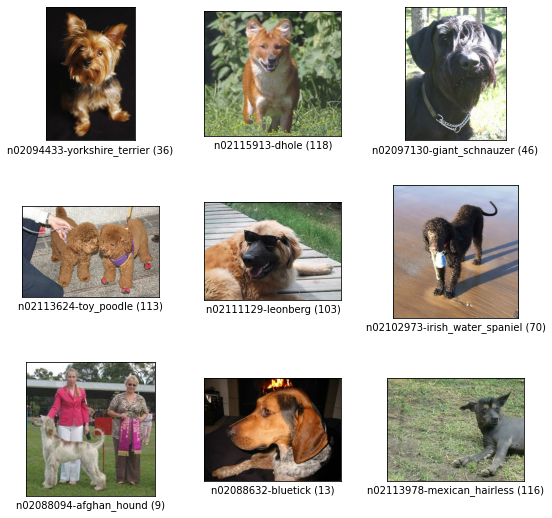

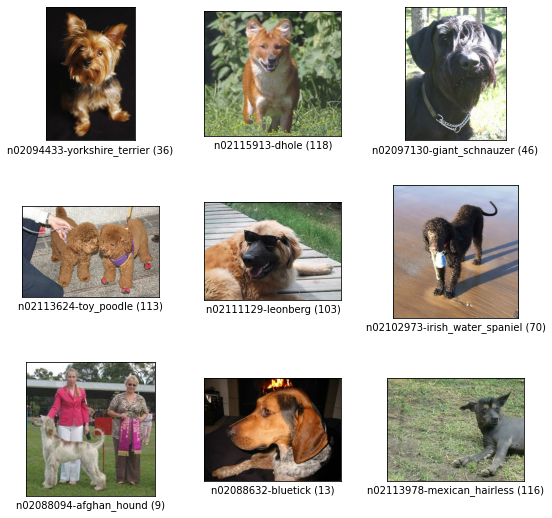

In [5]:
tfds.show_examples(ds_train, ds_info)

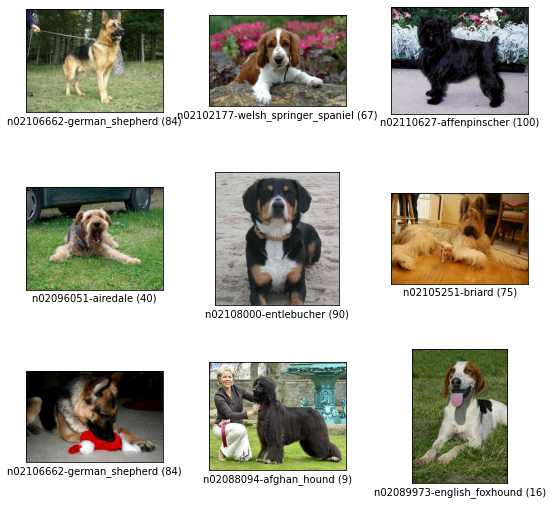

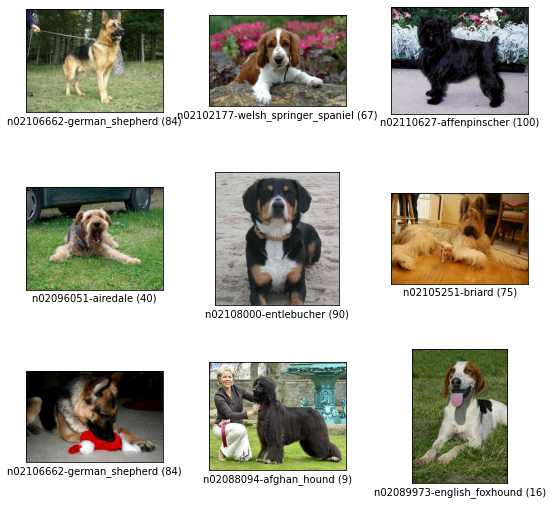

In [6]:
tfds.show_examples(ds_test, ds_info)

![image](https://user-images.githubusercontent.com/86637320/135971356-054d762f-3b1e-40a9-a68b-d0e925343e3d.png)

#### objects : bounding box!

다양한 bounding box 설정 기법이 존재한다.

- xywh : bounding box의 중심점을 x,y로 표기하고 사각형의 너비 w와 높이 h를 표기
- minmax : bounding box를 이루는 좌표의 최소값, 최대값 이용 표기

In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

#### 데이터 전처리

In [13]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


___

## 2. CAM 모델 

#### 모델 생성

In [20]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(units=num_classes,activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

In [21]:
cam_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

#### sparse_categorical_crossentropy, SGD

In [22]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [23]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - 315s 412ms/step - loss: 3.1915 - accuracy: 0.2731 - val_loss: 3.0492 - val_accuracy: 0.2591
Epoch 2/15
750/750 [==============================] - 318s 424ms/step - loss: 0.9332 - accuracy: 0.7457 - val_loss: 1.2549 - val_accuracy: 0.6411
Epoch 3/15
750/750 [==============================] - 309s 412ms/step - loss: 0.3726 - accuracy: 0.9105 - val_loss: 1.0858 - val_accuracy: 0.6879
Epoch 4/15
750/750 [==============================] - 309s 412ms/step - loss: 0.1207 - accuracy: 0.9833 - val_loss: 0.9405 - val_accuracy: 0.7310
Epoch 5/15
750/750 [==============================] - 309s 412ms/step - loss: 0.0386 - accuracy: 0.9969 - val_loss: 0.9033 - val_accuracy: 0.7453
Epoch 6/15
750/750 [==============================] - 309s 412ms/step - loss: 0.0187 - accuracy: 0.9999 - val_loss: 0.9006 - val_accuracy: 0.7461
Epoch 7/15
750/750 [==============================] - 309s 412ms/step - loss: 0.0121 - accuracy: 0.9995 - val_loss: 0.9161 -

#### 가중치 저장

In [24]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


___

## 3. 훈련된 CAM 모델 사용해보기

In [1]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

#### 이미지 확인하기

In [2]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


84


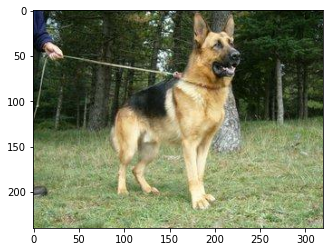

In [3]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

#### 모델 불러오기

In [4]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

#### CAM 만들기

In [5]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item) #img 전처리
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output]) 
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다. 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) #CAM을 표현할 이미지
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i] #=pooling 전 conv 정보에 가중치를 곱해서 CAM 이미지 생성

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

#### CAM : 2차원 이미지 => 원본 이미지에 weight 값 적용하기 위해선 3차원으로 변환 필요

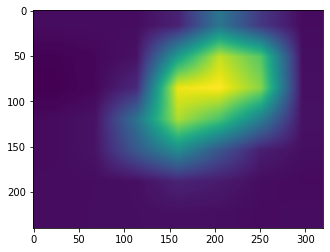

In [6]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [7]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

#### 강아지의 얼굴과 몸통 쪽의 weight가 높다

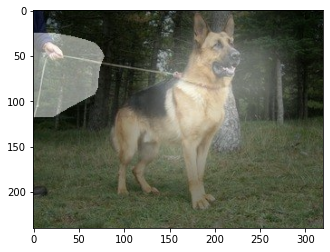

In [8]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

___

## 4. Grad-CAM

84


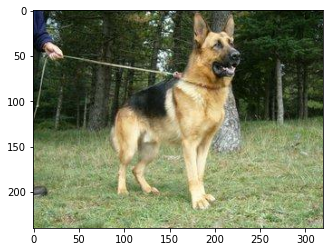

In [9]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [10]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2]) #grad_cam_iamge 생성
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

#### 결과 확인

- Grad-CAM의 경우 어떤 layer에서도 CAM을 뽑아낼 수 있다.

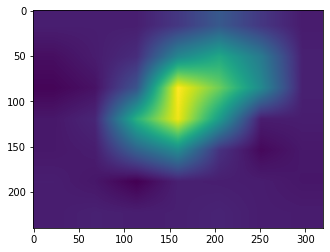

In [11]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

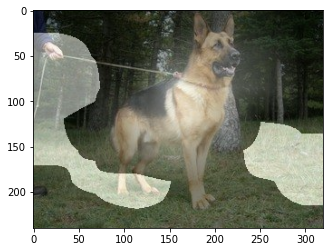

In [12]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

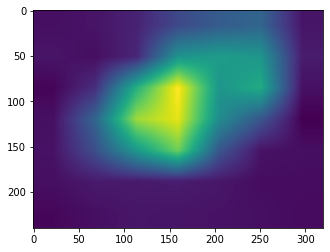

In [13]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_3_conv', item)
plt.imshow(grad_cam_image)
plt.show()

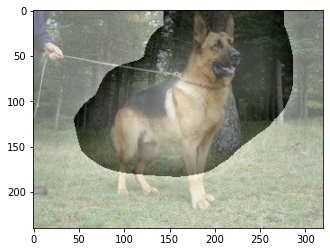

In [14]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

#### 낮은 단계의 layer에선 CAM 결과가 좋지 않다.

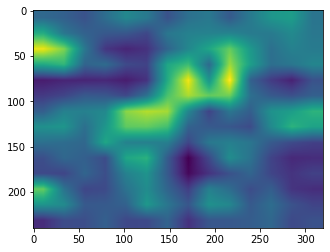

In [15]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

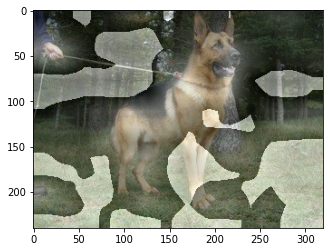

In [16]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

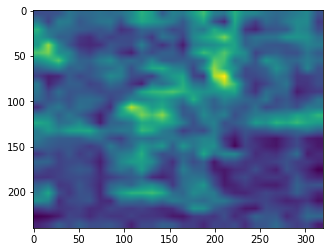

In [17]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

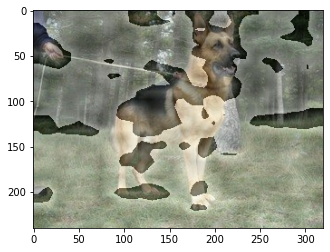

In [18]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

___

## 5. Detection with CAM

#### CAM

67


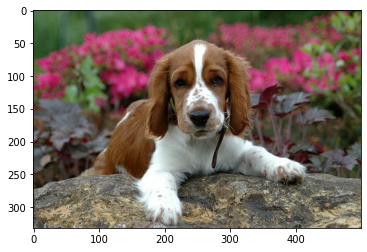

In [93]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

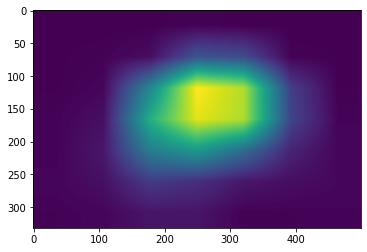

In [122]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [123]:
print(cam_image.mean())

0.16258015


#### bounding box

In [124]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0 #threshold 이하 값은 0으로 설정
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #컨투어 검출
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) #사각형 검출
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect) #좌표 검출
    return rect

In [125]:
rect = get_bbox(cam_image)
rect

array([[ 37, 135],
       [351, -46],
       [491, 195],
       [177, 377]])

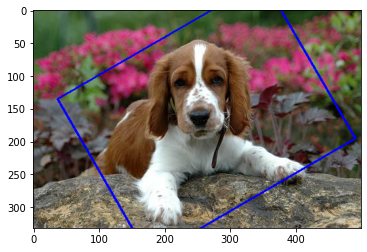

In [98]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### IoU를 통해 모델이 영역을 잘 찾았는 지 비교할 수 있다.

![image](https://user-images.githubusercontent.com/86637320/135982800-74ee4f20-3b0e-4c86-b1b9-28287b2b3c2e.png)

#### rect 좌표를 min-max 형태로 표시

In [99]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [100]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.13855421686746988, 0.074, 1.1355421686746987, 0.982]

#### ground truth

In [101]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [102]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

#### iou가 0.5정도로 보통 기준이 되는 0.5보다 정도이기 때문에 detection이 잘 됐음을 알 수 있다.

In [103]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5010362200124646

#### Grad-CAM

![image](https://user-images.githubusercontent.com/86637320/136145702-6cef6bd5-d139-419a-9d72-f9f88270d7bc.png)


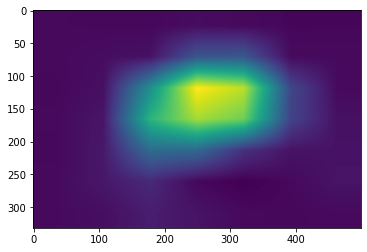

In [104]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [105]:
print(grad_cam_image.mean())

0.1432647


In [106]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0 #threshold 이하 값은 0으로 설정
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #컨투어 검출
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt) #사각형 검출
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect) #좌표 검출
    return rect

In [107]:
rect = get_bbox(grad_cam_image)
rect

array([[ 38, 133],
       [350, -50],
       [481, 171],
       [168, 355]])

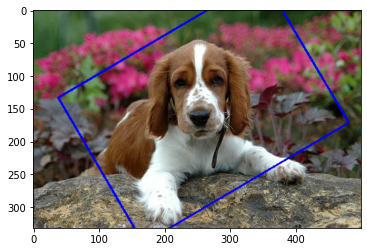

In [108]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

#### 예측

In [109]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.15060240963855423, 0.076, 1.069277108433735, 0.962]

#### ground-truth

In [110]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

#### IoU가 0.53으로 CAM 보다 더 나은 결과를 얻었다.

In [111]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5362985132995219

___

#### 결과 비교

#### Ground Truth

모든 좌표를 int로 해야 cv2.rectangel 작동

In [115]:
x1,y1,x2,y2 = int(item['objects']['bbox'][0][1]*image.shape[1]),int(item['objects']['bbox'][0][0]*image.shape[0]),\
int(item['objects']['bbox'][0][3]*image.shape[1]),int(item['objects']['bbox'][0][2]*image.shape[0])

In [116]:
print(x1,y1,x2,y2)

72 45 412 328


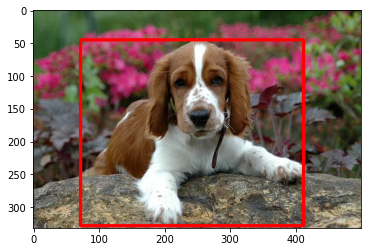

In [117]:
img = copy.deepcopy(item['image'])
gt = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),3)
plt.imshow(gt)

#### CAM

![image](https://user-images.githubusercontent.com/86637320/136146105-c58eccaa-f6d5-4187-96c0-09c2b9fb8ac4.png)


IoU : 0.501

#### Grad-CAM

![image](https://user-images.githubusercontent.com/86637320/136146145-e6b05220-746d-489b-9b25-c49169678dbe.png)

IoU : 0.536

#### IoU 수치만 보았을 때 Grad-CAM에서의 결과가 더 좋았다.

하지만 육안으론 둘 다 차이가 없어 보인다. 겹쳐서 나타내면 다음과 같다.

- 초록 사각형 : CAM
- 파란 사각형 : Grad-CAM

![image](https://user-images.githubusercontent.com/86637320/136147320-5f892c7d-f40f-4cce-bd91-3e036316bc2e.png)

___

# 정리

**XAI**의 한 분야인 CAM을 구현해보고 이를 통해 이미지별 bounding box를 확인해보았다. **CAM**의 경우 마지막 Layer에서만 사용될 수 있다는 단점이 있고 **Grad-CAM**은 어느 Layer에서든 cam을 얻을 수 있었다. 어떤 Layer를 택하느냐에 따라 다른 cam 결과를 얻을 수 있었다. 전반적으로 깊은 곳에 위치한 Layer의 cam이 Detection에 도움이될 만한 cam 정보를 가지고 있음을 확인했다. 동일한 이미지를 가지고 CAM과 Grad-CAM(마지막 out layer사용)을 모두 적용해본 결과 이미지에 따라 다르긴 하지만 전반적으로 비슷한 결과를 보여줬다. IoU라는 지표를 통해 더 적절한 bounding box(bbox)를 찾아낼 수 있었다. cam에서 bbox를 설정 시 **threshold**를 모두 동일한 값을 주었었는데 실제 활용 때는 최적의 bbox를 얻을 수 있는 threshold 값으로 작업 마다 다르게 설정하면 더 좋은 bbox를 얻을 수 있을 것이다.